## Neural Network Classification

Katherine Haynes  
October 16, 2019

Define a new class named `NeuralNetworkClassifier` that extends the class `NeuralNetwork`.  
The neural networks use mlutilities.py and optmizers.py, and all of the required classes and functions are included in this notebook.  

All code has been modified to run with torch on a GPU, which can be set by <br> 1) using torch (use_torch=True in initialization call), and <br>2) using a gpu (use_gpu=True in initialization call).
<br>If you try to use torch but a GPU with cuda is not available, it will print a message and continue using torch on a CPU.

###  Necessary Libraries

In [1]:
#Import Libraries
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as pltpatch  # for mlutilities
import matplotlib.collections as pltcoll # for mlutilities
import math
import numpy as np
import pandas #for testing different network setups
import sys
import time
import torch

### Machine Learning Utilities

In [2]:
#mlutilities.py
def draw(Vs, W, inputNames=None, outputNames=None, gray=False):

    def isOdd(x):
        return x % 2 != 0

    W = Vs + [W]
    nLayers = len(W)

    # calculate xlim and ylim for whole network plot
    #  Assume 4 characters fit between each wire
    #  -0.5 is to leave 0.5 spacing before first wire
    xlim = max(map(len, inputNames))/4.0 if inputNames else 1
    ylim = 0

    for li in range(nLayers):
        ni, no = W[li].shape  # no means number outputs this layer
        if not isOdd(li):
            ylim += ni + 0.5
        else:
            xlim += ni + 0.5

    ni, no = W[nLayers-1].shape
    if isOdd(nLayers):
        xlim += no + 0.5
    else:
        ylim += no + 0.5

    # Add space for output names
    if outputNames:
        if isOdd(nLayers):
            ylim += 0.25
        else:
            xlim += round(max(map(len,outputNames))/4.0)

    ax = plt.gca()

    character_width_factor = 0.07
    padding = 2
    if inputNames:
        x0 = max([1, max(map(len, inputNames)) * (character_width_factor * 3.5)])
    else:
        x0 = 1
    y0 = 0  # to allow for constant input to first layer
    # First Layer
    if inputNames:
        y = 0.55
        for n in inputNames:
            y += 1
            ax.text(x0 - (character_width_factor * padding), y, n, horizontalalignment="right", fontsize=20)

    patches = []
    for li in range(nLayers):
        thisW = W[li]
        maxW = np.max(np.abs(thisW))
        ni, no = thisW.shape
        if not isOdd(li):
            # Even layer index. Vertical layer. Origin is upper left.
            # Constant input
            ax.text(x0-0.2, y0+0.5, '1', fontsize=20)
            for i in range(ni):
                ax.plot((x0, x0+no-0.5), (y0+i+0.5, y0+i+0.5), color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0+1+i-0.5, x0+1+i-0.5), (y0, y0+ni+1), color='gray')
            # cell "bodies"
            xs = x0 + np.arange(no) + 0.5
            ys = np.array([y0+ni+0.5]*no)
            for x, y in zip(xs, ys):
                patches.append(pltpatch.RegularPolygon((x, y-0.4), 3, 0.3, 0, color ='#555555'))
            # weights
            if gray:
                colors = np.array(["black", "gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red", "green"])[(thisW.flat >= 0)+0]
            xs = np.arange(no) + x0+0.5
            ys = np.arange(ni) + y0 + 0.5
            coords = np.meshgrid(xs, ys)
            for x, y, w, c in zip(coords[0].flat, coords[1].flat,
                                  np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w, w, color=c))
            y0 += ni + 1
            x0 += -1  # shift for next layer's constant input
        else:
            # Odd layer index. Horizontal layer. Origin is upper left.
            # Constant input
            ax.text(x0+0.5, y0-0.2, '1', fontsize=20)
            # input lines
            for i in range(ni):
                ax.plot((x0+i+0.5,  x0+i+0.5), (y0, y0+no-0.5), color='gray')
            # output lines
            for i in range(no):
                ax.plot((x0, x0+ni+1), (y0+i+0.5, y0+i+0.5), color='gray')
            # cell "bodies"
            xs = np.array([x0 + ni + 0.5] * no)
            ys = y0 + 0.5 + np.arange(no)
            for x, y in zip(xs, ys):
                patches.append(pltpatch.RegularPolygon((x-0.4, y), 3, 0.3, -np.pi/2, color ='#555555'))
            # weights
            if gray:
                colors = np.array(["black", "gray"])[(thisW.flat >= 0)+0]
            else:
                colors = np.array(["red", "green"])[(thisW.flat >= 0)+0]
            xs = np.arange(ni)+x0 + 0.5
            ys = np.arange(no)+y0 + 0.5
            coords = np.meshgrid(xs, ys)
            for x, y, w, c in zip(coords[0].flat, coords[1].flat,
                                  np.abs(thisW/maxW).flat, colors):
                patches.append(pltpatch.Rectangle((x-w/2, y-w/2), w, w, color=c))
            x0 += ni + 1
            y0 -= 1  # shift to allow for next layer's constant input

    collection = pltcoll.PatchCollection(patches, match_original=True)
    ax.add_collection(collection)

    # Last layer output labels
    if outputNames:
        if isOdd(nLayers):
            x = x0+1.5
            for n in outputNames:
                x += 1
                ax.text(x, y0+0.5, n, fontsize=20)
        else:
            y = y0+0.6
            for n in outputNames:
                y += 1
                ax.text(x0+0.2, y, n, fontsize=20)
    ax.axis([0, xlim, ylim, 0])
    ax.axis('off')

### Optimizers

In [3]:
#SGD Optimizer
def sgd(w, error_f, fargs=[], n_iterations=100, error_gradient_f=None,
        eval_f=lambda x: x, save_wtrace=False, verbose=False,
        use_torch=False, use_gpu=False,
        learning_rate=0.001, momentum_rate=0.0):

    start_time = time.time()
    start_time_last_verbose = start_time

    mydest = 'cuda' if use_gpu else 'cpu'
    if use_torch:
        if isinstance(w, np.ndarray):
            w = torch.tensor(w, dtype=torch.float,
                             requires_grad=True).to(mydest)
        else:
            w = (w.clone().detach().requires_grad_(True)).to(mydest)
        wtrace = [w.clone().detach()] if save_wtrace else None
    else:
        w = w.copy()
        wtrace = [w.copy()] if save_wtrace else None

    ftrace = [eval_f(error_f(w, *fargs))]
    
    w_change = 0

    for iteration in range(n_iterations):

        error = error_f(w, *fargs)

        if use_torch:
            error.backward(retain_graph=True)
            with torch.no_grad():
                w_change = -learning_rate * w.grad + momentum_rate * w_change
                w += w_change
                w.grad.zero_()
            if save_wtrace:
                wtrace.append(w.clone().detach())
            ftrace.append(eval_f(error).detach())

        else:
            grad = error_gradient_f(w, *fargs)
            w_change = -learning_rate * grad + momentum_rate * w_change
            w += w_change
            if save_wtrace:
                wtrace.append(w.copy())
            ftrace.append(eval_f(error))

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - start_time_last_verbose
            eval = eval_f(error) # .item() if use_torch else eval_f(error)
            print(f'sgd: Iteration {iteration+1:d} ObjectiveF={eval:.5f} ' \
                + f'Seconds={seconds:.3f}')
            start_time_last_verbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 2,:] \
                    if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 2],
            'reason': 'iterations',
            'time': time.time() - start_time}


In [4]:
#Adam Optimizer
def adam(w, error_f, fargs=[], n_iterations=100, error_gradient_f=None,
         eval_f=lambda x: x, save_wtrace=False, verbose=False,
         use_torch=False, use_gpu=False,
         learning_rate=0.001, momentum_rate=None):


    start_time = time.time()
    start_time_last_verbose = start_time

    mydest = 'cuda' if use_gpu else 'cpu'
    if use_torch:
        if isinstance(w, np.ndarray):
            w = torch.tensor(w, dtype=torch.float,
                             requires_grad=True).to(mydest)
        else:
            w = w.clone().detach().requires_grad_(True)
        wtrace = [w.clone()] if save_wtrace else None
    else:
        w = w.copy()
        wtrace = [w.copy()] if save_wtrace else None

        
    beta1 = 0.9
    beta2 = 0.999
    alpha = learning_rate
    epsilon = 10e-8
    nW = len(w)
    g = torch.zeros((nW)).to(mydest) if use_torch else np.zeros((nW))
    g2 = torch.zeros((nW)).to(mydest) if use_torch else np.zeros((nW))
    beta1t = beta1
    beta2t = beta2

    ftrace = [eval_f(error_f(w, *fargs))]
    
    for iteration in range(n_iterations):

        error = error_f(w, *fargs)

        if use_torch:
            error.backward(retain_graph=True)
            with torch.no_grad():
                g = beta1 * g + (1 - beta1) * w.grad
                g2 = beta2 * g2 + (1 - beta2) * w.grad * w.grad
                g_corrected = g / (1 - beta1t)
                g2_corrected = g2 / (1 - beta2t)
                # alphat = alpha * torch.sqrt(1 - beta2t) / (1 - beta1t)
                w -= alpha * g_corrected / (torch.sqrt(g2_corrected) + epsilon)
                w.grad.zero_()

            if save_wtrace:
                wtrace.append(w.clone().detach())
            ftrace.append(eval_f(error).detach())

        else:
            grad = error_gradient_f(w, *fargs)
            g = beta1 * g + (1 - beta1) * grad
            g2 = beta2 * g2 + (1 - beta2) * grad * grad
            g_corrected = g / (1 - beta1t)
            g2_corrected = g2 / (1 - beta2t)
            w -= alpha * g_corrected / (np.sqrt(g2_corrected) + epsilon)
            if save_wtrace:
                wtrace.append(w.copy())
            ftrace.append(eval_f(error))

        beta1t *= beta1
        beta2t *= beta2


        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and (iteration + 1) % max(1, iterations_per_print) == 0:
            seconds = time.time() - start_time_last_verbose
            eval = eval_f(error) # .item() if use_torch else eval_f(error)
            print(f'adam: Iteration {iteration+1:d} ObjectiveF={eval:.5f} ' \
                + f'Seconds={seconds:.3f}')
            start_time_last_verbose = time.time()

    return {'w': w,
            'f': error_f(w, *fargs),
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 2,:] \
                 if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 2],
            'reason': 'iterations',
            'time': time.time() - start_time}

In [5]:
#SCG Optimizer
# Scaled Conjugate Gradient algorithm from
#  "A Scaled Conjugate Gradient Algorithm for Fast Supervised Learning"
#  by Martin F. Moller
#  Neural Networks, vol. 6, pp. 525-533, 1993
#
#  Adapted by Chuck Anderson from the Matlab implementation by Nabney
#   as part of the netlab library.
#

def scg(w, error_f, fargs=[], n_iterations=100, error_gradient_f=None,
        eval_f=lambda x: x, save_wtrace=False, verbose=False,
        use_torch=False, use_gpu=False,
        learning_rate=None, momentum_rate=None):  # not used here

    print_times = False
    start_time = time.time()
    start_time_last_verbose = start_time
    float_precision = sys.float_info.epsilon
    mydest = 'cuda' if use_gpu else 'cpu'
    
    if use_torch:
        if isinstance(w, np.ndarray):
            w = torch.tensor(w, dtype=torch.float, \
                             requires_grad=True).to(mydest)
        else:
            w = (w.clone().detach().requires_grad_(True)).to(mydest)
        wtrace = [w.clone()] if save_wtrace else None
        isnan = torch.isnan
        sqrt = torch.sqrt
    else:
        w = w.copy()
        wtrace = [w.copy()] if save_wtrace else None
        isnan = np.isnan
        sqrt = math.sqrt
    
    sigma0 = 1.0e-6
    error_old = error_f(w, *fargs)
    error_now = error_old
    if use_torch:
        error_now.backward(retain_graph=True)
        gradnew = w.grad.clone() #(w.grad.clone()).to(mydest)
        w.grad.zero_()
        ftrace = [eval_f(error_old).detach()]
    else:
        gradnew = error_gradient_f(w, *fargs)
        ftrace = [eval_f(error_old)]

    gradold = gradnew
    d = -gradnew      # Initial search direction.
    success = True    # Force calculation of directional derivs.
    nsuccess = 0      # nsuccess counts number of successes.
    beta = 1.0e-6     # Initial scale parameter. Lambda in Moeller.
    betamin = 1.0e-15 # Lower bound on scale.
    betamax = 1.0e20  # Upper bound on scale.
    nvars = len(w)
    iteration = 1     # count of number of iterations

    thisIteration = 1

    startTime = time.time()
    while thisIteration <= n_iterations:

        if print_times:
            print("It: ", thisIteration)
            print("  Time1: ", time.time() - startTime)
        if success:
            mu = d.T @ gradnew
            if mu >= 0:
                d = -gradnew
                mu = d.T @ gradnew
            kappa = d.T @ d

            if print_times:
                print("  Time1a: ", time.time() - startTime)
                
            if isnan(kappa):
                print('kappa', kappa)

            if kappa < float_precision:
                return {'w': w,
                        'f': error_now,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] \
                             if save_wtrace else None, 
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'limit on machine precision',
                        'time': time.time() - startTime}
            sigma = sigma0 / sqrt(kappa)

            if print_times:
                print("  Time2: ",time.time() - startTime)
                
            if use_torch:
                w_smallstep = (w.detach() + sigma * d).requires_grad_(True)
                if print_times:
                    print("  Time2a: ",time.time() - startTime)
                err = error_f(w_smallstep, *fargs)
                if print_times:
                    print("  Time2b: ",time.time()  - startTime)
                err.backward(retain_graph=True)
                if print_times:
                    print("  Time2c:  ",time.time() - startTime)
                g_smallstep = w_smallstep.grad.clone()
                w_smallstep.grad.zero_()
            else:
                w_smallstep = w + sigma * d
                error_f(w_smallstep, *fargs)
                g_smallstep = error_gradient_f(w_smallstep, *fargs)

            if print_times:
                print("  Time3: ",time.time() - startTime)
            theta = d.T @ (g_smallstep - gradnew) / sigma
            if isnan(theta):
                print(f'theta {theta} sigma {sigma} d[0] {d[0]} g_smallstep[0]'
                    + f'{g_smallstep[0]} gradnew[0] {gradnew[0]}')

        ## Increase effective curvature and evaluate step size alpha.
        delta = theta + beta * kappa
        if isnan(delta):
            print(f'delta is NaN theta {theta} beta {beta} kappa {kappa}')
        elif delta <= 0:
            delta = beta * kappa
            beta = beta - theta / kappa

        #if np.abs(delta) <= np.finfo(type(delta)).eps:
        if ((delta >= -float_precision) and (delta <= float_precision)):
            success = False
            error_now = error_old
        else:
            alpha = -mu / delta
            
            ## Calculate the comparison ratio Delta
            if use_torch:
                wnew = (w.detach() + alpha * d).requires_grad_(True)
            else:
                wnew = w + alpha * d

            if print_times:
                print("  Time3b: ",time.time() - startTime)
            error_new = error_f(wnew, *fargs)

            if print_times:
                print("  Time4: ",time.time() - startTime)
            Delta = 2 * (error_new - error_old) / (alpha * mu)
            if not isnan(Delta) and Delta  >= 0:
                success = True
                nsuccess += 1
                if use_torch:
                    w = wnew.detach().requires_grad_(True)
                else:
                    w[:] = wnew
                error_now = error_new
            else:
                success = False
                error_now = error_old

        iterations_per_print = math.ceil(n_iterations/10)
        if verbose and thisIteration % max(1, iterations_per_print) == 0:
            seconds = time.time() - start_time_last_verbose
            print(f'SCG: Iter {iteration:d} ObjF={eval_f(error_now):.5f}'
                + f'Scale={beta:.3e} Seconds={seconds:.3f}')
            start_time_last_verbose = time.time()
        if use_torch:
            if save_wtrace:
                wtrace.append(w.clone().detach())
            ftrace.append(eval_f(error_now).detach())
        else:
            if save_wtrace:
                wtrace.append(w.copy())
            ftrace.append(eval_f(error_now))


        if success:
            error_old = error_new
            gradold[:] = gradnew
            if use_torch:
                error_new.backward(retain_graph=True)
                gradnew = wnew.grad.clone()
                wnew.grad.zero_()
            else:
                gradnew[:] = error_gradient_f(w, *fargs)

            # If the gradient is zero then we are done.
            gg = gradnew.T @ gradnew
            #if gg == 0:
            if gg < 1.E-12:
                return {'w': w,
                        'f': error_now,
                        'n_iterations': iteration,
                        'wtrace': np.array(wtrace)[:iteration + 1, :] \
                             if save_wtrace else None,
                        'ftrace': np.array(ftrace)[:iteration + 1],
                        'reason': 'zero gradient',
                        'time': time.time() - start_time}

        if isnan(Delta) or Delta < 0.25:
            beta = min(4.0 * beta, betamax)
        elif Delta > 0.75:
            beta = max(0.5 * beta, betamin)

        # Update search direction using Polak-Ribiere formula, or re-start
        # in direction of negative gradient after nparams steps.
        if nsuccess == nvars:
            d[:] = -gradnew
            nsuccess = 0
        elif success:
            gamma = (gradold - gradnew).T @ (gradnew / mu)
            d[:] = gamma * d - gradnew

        thisIteration += 1
        iteration += 1

        # If we get here, then we haven't terminated in the given number
        # of iterations.

    return {'w': w,
            'f': error_now,
            'n_iterations': iteration,
            'wtrace': np.array(wtrace)[:iteration + 1,:] \
                 if save_wtrace else None,
            'ftrace': np.array(ftrace)[:iteration + 1],
            'reason': 'did not converge',
            'time': time.time() - start_time}

## Definition of `NeuralNetwork`

In [6]:
#NeuralNetwork Class

class NeuralNetwork:

    def __init__(self, n_inputs, n_hiddens_list, n_outputs, use_torch=False, use_gpu=False):

        if not isinstance(n_hiddens_list, list):
            raise Exception('NeuralNetwork: n_hiddens_list must be a list.')
 
        if len(n_hiddens_list) == 0:
            self.n_hidden_layers = 0
        elif n_hiddens_list[0] == 0:
            self.n_hidden_layers = 0
        else:
            self.n_hidden_layers = len(n_hiddens_list)
            
        self.n_inputs = n_inputs
        self.n_hiddens_list = n_hiddens_list
        self.n_outputs = n_outputs
        
        # Do we have any hidden layers?
        self.Vs = []
        ni = n_inputs
        for layeri in range(self.n_hidden_layers):
            n_in_layer = self.n_hiddens_list[layeri]
            self.Vs.append(1 / np.sqrt(1 + ni) *
                            np.random.uniform(-1, 1, size=(1 + ni, n_in_layer)))
            ni = n_in_layer
        self.W = 1/np.sqrt(1 + ni) * np.random.uniform(-1, 1, size=(1 + ni, n_outputs))

        # Set gpu properties
        self.mydest = 'cpu'
        self.use_gpu = use_gpu
        if use_gpu:
            if torch.cuda.is_available():
                self.mydest = 'cuda'
            else:
                print("GPU not available!")
                self.use_gpu = False
        
        # Set torch vs numpy properties
        self.use_torch = use_torch
        if use_torch:
            self.Vs = [torch.tensor(V, dtype=torch.float).to(self.mydest) for V in self.Vs]
            self.W = torch.tensor(self.W, dtype=torch.float).to(self.mydest)
            self.tanh = torch.tanh
            self.mean = torch.mean
            self.sqrt = torch.sqrt
        else:
            self.tanh = np.tanh
            self.mean = np.mean
            self.sqrt = np.sqrt
 
        # Member variables for standardization
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None
        
        self.trained = False
        self.reason = None
        self.error_trace = None
        self.n_epochs = None
        self.training_time = None

    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_list}, ' + \
              f'{self.n_outputs}, use_torch={self.use_torch}, use_gpu={self.use_gpu})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds. ' + \
                   f'\n   Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '  Network is not trained.'
        return str

    def _standardizeX(self, X):
        result = (X - self.Xmeans) / self.XstdsFixed
        result[:, self.Xconstant] = 0.0
        return result

    def _unstandardizeX(self, Xs):
        return self.Xstds * Xs + self.Xmeans

    def _standardizeT(self, T):
        result = (T - self.Tmeans) / self.TstdsFixed
        result[:, self.Tconstant] = 0.0
        return result

    def _unstandardizeT(self, Ts):
        return self.Tstds * Ts + self.Tmeans

    def _pack(self, Vs, W):
        if self.use_torch:
            return torch.cat([V.reshape(-1) for V in Vs] + \
                             [W.reshape(-1)]).to(self.mydest)
        else:
            return np.hstack([V.flat for V in Vs] + [W.flat])

    def _unpack(self, w):
        first = 0
        n_this_layer = self.n_inputs
        for i in range(self.n_hidden_layers):
            self.Vs[i][:] = w[first:first + (1 + n_this_layer) * 
                              self.n_hiddens_list[i]].reshape((1 + \
                              n_this_layer, self.n_hiddens_list[i]))
            first += (1 + n_this_layer) * self.n_hiddens_list[i]
            n_this_layer = self.n_hiddens_list[i]
        self.W[:] = w[first:].reshape((1 + n_this_layer, self.n_outputs))
        if (self.use_torch and self.use_gpu):
               self.W = self.W.to(self.mydest)

    def _forward_pass(self, X):
        # Assume weights already unpacked
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            if (self.use_torch and self.use_gpu):
                V = self.Vs[i].to(self.mydest)
            else:
                V = self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = Z_prev @ self.W[1:, :] + self.W[0:1, :]
        if (self.use_torch and self.use_gpu):
            Y = Y.to(self.mydest)
        return Y, Z

    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        return 0.5 * self.mean((T - Y)**2)

    # Only used if use_torch=False
    def _gradientF(self, w, X, T):
        self._unpack(w)
        Y, Z = self._forward_pass(X)
        # Do backward pass, starting with delta in output layer
        delta = -(T - Y) / (X.shape[0] * T.shape[1])
        # Another way to define dEdW without calling np.insert                        
        dW = np.vstack((np.sum(delta, axis=0), Z[-1].T @ delta))
        dVs = []
        delta = (1 - Z[-1]**2) * (delta @ self.W[1:, :].T)
        for Zi in range(self.n_hidden_layers, 0, -1):
            Vi = Zi - 1  # because X is first element of Z
            dV = np.vstack((np.sum(delta, axis=0), Z[Zi-1].T @ delta))
            dVs.insert(0, dV)  # like append, but at front of list of dVs
            delta = (delta @ self.Vs[Vi][1:, :].T) * (1 - Z[Zi-1]**2)
        return self._pack(dVs, dW)

    def _setup_standardize(self, X, T):
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xconstant = self.Xstds == 0
            self.XstdsFixed = copy.copy(self.Xstds)
            self.XstdsFixed[self.Xconstant] = 1

        if self.Tmeans is None:
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            self.Tconstant = self.Tstds == 0
            self.TstdsFixed = copy.copy(self.Tstds)
            self.TstdsFixed[self.Tconstant] = 1
        
    def _objective_to_actual(self, objective):
        return self.sqrt(objective)
    
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]})'
                          + f'(not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float).to(self.mydest) # 32 bit
            T = torch.tensor(T, dtype=torch.float).to(self.mydest)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        
        try:
            algo = [sgd, adam, scg][['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of 'scg', 'sgd' or 'adam'")            

        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, T], n_epochs,
                      self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch, use_gpu=self.use_gpu, 
                      save_wtrace=save_weights_history)

        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] # * self.Tstds # to _unstandardize the MSEs
        self.n_epochs = n_epochs #len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] if save_weights_history else None
        self.training_time = result['time']
        return self

    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float).to(self.mydest)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        return (Y, Z[1:]) if all_outputs else Y

    def get_n_epochs(self):
        return self.n_epochs

    def get_error_trace(self):
        return self.error_trace

    def get_training_time(self):
        return self.training_time

    def get_weight_history(self):
        return self.weight_history

    def draw(self, input_names=None, output_names=None, gray=False):
        if self.use_torch:
            Vs = [V.detach().cpu().numpy() for V in self.Vs]
            W = self.W.detach().cpu().numpy()
        else:
            Vs = self.Vs
            W = self.W
        draw(Vs, W, input_names, output_names, gray)

## Definition of `NeuralNetworkClassifier`

In [7]:
#NeuralNetworkClassifier
# Extends the NeuralNetwork class, only altering methods that need
# to be modified to do classification.

class NeuralNetworkClassifier(NeuralNetwork):
    
    # Contructor
    def __init__(self, n_inputs, n_hiddens_list, classes, 
                 use_torch=False, use_gpu=False):
        
        # Force n_hiddens_list to be a list
        if not isinstance(n_hiddens_list, list):
            raise Exception(
                    'NeuralNetworkClassifier: n_hiddens_list must be a list.')
            
        # Call the constructor for NeuralNetwork, passing in the 
        # number of unique class names as the number of outputs
        super().__init__(n_inputs, n_hiddens_list, len(classes), 
                         use_torch=use_torch, use_gpu=use_gpu)

        # Store as member variables things needed by instances of this class.
        self.classes = np.array(classes)
        
        if use_torch:
                self.argmax = torch.argmax
                self.copy = torch.clone
                self.exp = torch.exp
                self.isfinite = torch.isfinite
                self.log = torch.log
                self.mean = torch.mean
                self.sum = torch.sum
                self.unique = torch.unique
                self.where = torch.where
        else:
                self.argmax = np.argmax
                self.copy = np.copy
                self.exp = np.exp
                self.isfinite = np.isfinite
                self.log = np.log
                self.mean = np.mean
                self.sum = np.sum
                self.unique = np.unique
                self.where = np.where

    # Compute the string representation for the NeuralNetwork
    def __repr__(self):
        str = f'{type(self).__name__}({self.n_inputs},'
        str += f' {self.n_hiddens_list}, {self.classes},'
        str += f' use_torch={self.use_torch}, use_gpu={self.use_gpu})'
        if self.trained:
            str += f'\n   Network was trained for {self.n_epochs} epochs'
            str += f' that took {self.training_time:.4f} seconds.'
            str += f'  Final objective value is {self.error_trace[-1]:.3f}'
        else:
            str += '\n   Network is not trained.'
        return str

    # For classifiers, do not standardize the targets.
    # Instead, just return the T matrix.
    def _standardizeT(self, T):
        return T
    
    # For classifiers, since we do not standardize T,
    # do not unstandardize T.  Instead, return T matrix.
    def _unstandardizeT(self, T):
        return T

    # Set up indicator variables for T.
    def _makeIndicatorVars(self, T):       
        # Make sure T is two-dimensional.
        # Should be nSamples x 1.
        Ti = self.copy(T)
        if Ti.ndim == 1:
           Ti = Ti.reshape((-1,1))
        if (self.use_torch):
            return (Ti == torch.unique(Ti)).int().to(self.mydest)
        else:
            return (Ti == np.unique(Ti)).astype(int)

    # Set up softmax function.
    def _softMax(self, X, w):
        fs = self.exp(X @ w[1:,:] + w[0:1, :])
        denom = self.sum(fs, axis=1).reshape((-1,1))
        return (fs/denom).to(self.mydest) if self.use_gpu else fs/denom
        
    # Pass through the data and make predictions for Y.
    def _forward_pass(self, X):
        # Assume weights already unpacked
        Z_prev = X  # output of previous layer
        Z = [Z_prev]
        for i in range(self.n_hidden_layers):
            V = self.Vs[i].to(self.mydest) if self.use_gpu else self.Vs[i]
            Z_prev = self.tanh(Z_prev @ V[1:, :] + V[0:1, :])
            Z.append(Z_prev)
        Y = self._softMax(Z_prev,self.W)
        return Y, Z

    # Objective function new
    def _objectiveF(self, w, X, T):
        self._unpack(w)
        Y, _ = self._forward_pass(X)
        if self.use_torch:
           M = self.mean(T.float() * self.log(Y))
        else:
            M = self.mean(T * self.log(Y))
        return -M

    # Convert the objective function to the likelihood
    def _objective_to_actual(self, neg_mean_log_likelihood):
        return self.exp(- neg_mean_log_likelihood)

    # Train the network
    def train(self, X, T, n_epochs, method='scg',
              verbose=False, save_weights_history=False,
              learning_rate=0.001, momentum_rate=0.0): # only for sgd and adam

        printTime=False
        timeStart = time.time()
        if X.shape[1] != self.n_inputs:
            raise Exception(f'train: number of columns in X ({X.shape[1]})'
               + f'(not equal to number of network inputs ({self.n_inputs})')
        
        if self.use_torch:
            X = torch.tensor(X, dtype=torch.float).to(self.mydest)
            T = torch.tensor(T, dtype=torch.float).to(self.mydest)

        self._setup_standardize(X, T)
        X = self._standardizeX(X)
        T = self._standardizeT(T)
        Ti = self._makeIndicatorVars(T)
        
        try:
            algo = [sgd, adam, scg]\
                [['sgd', 'adam', 'scg'].index(method)]
        except:
            raise Exception("train: method={method} not one of "
                            + "'scg', 'sgd' or 'adam'")            
        
        #verbose=False
        result = algo(self._pack(self.Vs, self.W),
                      self._objectiveF,
                      [X, Ti], n_epochs,
                      self._gradientF,  # not used if scg
                      eval_f=self._objective_to_actual,
                      learning_rate=learning_rate, momentum_rate=momentum_rate,
                      verbose=verbose, use_torch=self.use_torch, use_gpu=self.use_gpu,
                      save_wtrace=save_weights_history)
        self._unpack(result['w'])
        self.reason = result['reason']
        self.error_trace = result['ftrace'] #*self.Tstds #_unstandardize MSEs
        self.n_epochs = len(self.error_trace) - 1
        self.trained = True
        self.weight_history = result['wtrace'] \
            if save_weights_history else None
        self.training_time = result['time']
        
        if printTime:
            print("TIME TRAINING: ", time.time()-timeStart)
        return self
    
    def use(self, X, all_outputs=False):
        if self.use_torch:
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(X, dtype=torch.float).to(self.mydest)
        X = self._standardizeX(X)
        Y, Z = self._forward_pass(X)
        Y = self._unstandardizeT(Y)
        Y_classes = self.classes[self.argmax(Y,axis=1)]
        Y_classes = Y_classes[...,None] \
                    if np.ndim(Y_classes) == 1 else Y_classes
        if self.use_torch:
            Y = Y.detach().cpu().numpy()
            Z = [Zi.detach().cpu().numpy() for Zi in Z]
        if all_outputs:
            return Y_classes, Y, Z[1:]
        else:
            return Y_classes, Y
        #return (Y_classes, Y, Z[1:]) if all_outputs else Y_classes, Y

## Example Neural Network Tests

In [9]:
#Test Options
testOpt = 'adam'  #Chose between sgd, adam, and scg
testIter = 50    #Set number of iterations
testTorch = False  #True uses torch, False uses numpy
testGPU = False    #True uses GPU (if available)

testLR = 0.1  #Learning Rate for sgd and adam
testMR = 0.5  #Momentum Rate for sgd and adam

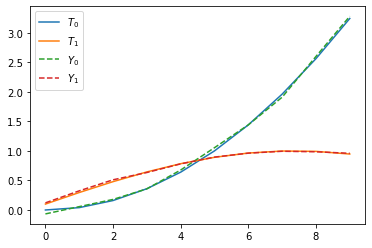

In [10]:
#Test of NeuralNetwork

%matplotlib inline
X = np.arange(20).reshape((10, 2)) * 0.1
T = np.hstack((X[:, 0:1]**2, np.sin(X[:, 1:2])))

#To plot original
#plt.plot(T)
#plt.xlabel('Sample Index')
#plt.legend(['Square', 'Sine']);

np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.
nnet = NeuralNetwork(2, [10, 10], 2, use_torch=testTorch, use_gpu=testGPU)
nnet.train(X, T, testIter, method=testOpt, learning_rate=testLR, momentum_rate=testMR)

#To plot RMSE vs Epoch:
#plt.plot(nnet.get_error_trace())
#plt.xlabel('Epoch')
#plt.ylabel('RMSE')

#To plot resulting fits:
Y = nnet.use(X)
plt.plot(T)
plt.plot(Y, '--')
plt.legend(['$T_0$', '$T_1$', '$Y_0$', '$Y_1$']);

## Example Neural Network Classification Tests

In [11]:
#Test Options
tcMethod = 'scg'  #Chose between sgd, adam, and scg
tcIter = 100    #Set number of iterations
tcTorch = True  #True uses torch, False uses numpy
tcGPU = False    #True uses GPU (if available)

tcLR = 0.1  #Learning Rate for sgd and adam
tcMR = 0.5  #Momentum Rate for sgd and adam

NeuralNetworkClassifier(2, [10, 10], [0 1], use_torch=True, use_gpu=False)
   Network was trained for 100 epochs that took 1.5118 seconds.  Final objective value is 1.000



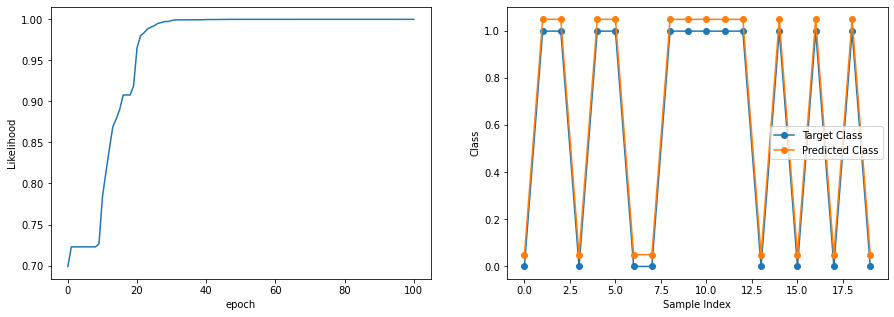

In [12]:
#Test of NeuralNetworkClassifier
np.random.seed(42)  # only to help you compare your output to mine.  Do not use otherwise.
n_samples = 20
X = np.random.choice(3, (n_samples, 2))  # randomly selected integers 0, 1, 2
T = (X[:, 0:1] == X[:, 1:2]).astype(int)  # where the two inputs are equal
classes = [0, 1]

np.random.seed(42)
nnet_new = NeuralNetworkClassifier(2, [10, 10], [0, 1], use_torch=tcTorch, use_gpu=tcGPU)
nnet_new.train(X, T, tcIter)
Yc_classes, Yc = nnet_new.use(X)
print(nnet_new)
print('')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(nnet_new.get_error_trace())
plt.xlabel('epoch')
plt.ylabel('Likelihood')

plt.subplot(1, 2, 2)
plt.plot(T, 'o-')
plt.plot(Yc_classes + 0.05, 'o-')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend(['Target Class', 'Predicted Class']);

## Real Data Set
I used the neural network classifier developed here to test cloud prediction using a dataset provided to me by John Haynes at CIRA.  The dataset includes GOES satellite data and relative humitidy from ECMWF as input data.  These are used to predict either clear conditions (target value 0) or clouds under 4 km (target value 1).  There are 14 total input columns, including different satellite channels, relative humidity at different atmospheric heights, solar zenith angle, and latitude.  The target values are combined data from the CloudSat and CALIPSO satellites.  

The dataset included both training and testing data.  The training data contained 1696429 collocated input and target samples and the testing data contained 809446 samples.  Because the training dataset it large and time consuming to test for this homework assignment, I developed code that combines the original traininga and testing datasets and resampled using different training fractions.  For the purpose of the results shown here, I used 20% of the data to train and 80% for testing.

The predictability of clouds using this dataset has previously been investigated with a random forest, where so far the best results yielded ~82% accuracy.  No work had been done using neural networks prior to this assignment.

NOTE: The data to run this portion of the notebook can be obtained at:  
https://bit.ly/2RZgD0j  
To use, please place the 'clouddata' folder into the directory where this notebook is running.  
Please use discretion with this data, as it is being used for current research that has not been published. 

### Load the data

This notebook assumes that the data is included in the local clouddata directory.  
In order to run this notebook without the data, please set the below flag haveData=False.

In [13]:
#Dataset options
haveData = True
useNewSplit = True
trainFraction = 0.2
printNewSplit = True

In [14]:
#Load and repartition the datasets
if haveData:
    filename = './clouddata/training_data3.npz'
    testname = './clouddata/testing_data3.npz'

    dat = np.load(filename)
    X = dat['features']
    T = dat['labels'].reshape(-1,1)
    datTest = np.load(testname)
    XTest = datTest['features']
    TTest = datTest['labels'].reshape(-1,1)

    if useNewSplit:
        Xall = np.concatenate((X, XTest))
        Tall = np.concatenate((T, TTest))
        cloudyI, _ = np.where(Tall == 1)
        clearI,  _ = np.where(Tall == 0)
        cloudyI = np.random.permutation(cloudyI)
        clearI = np.random.permutation(clearI)
        nCloudy = round(trainFraction*len(cloudyI))
        nClear = round(trainFraction*len(clearI))
    
        rowsTrain = np.hstack((cloudyI[:nCloudy], clearI[:nClear]))
        X = Xall[rowsTrain, :]
        T = Tall[rowsTrain, :]
        rowsTest = np.hstack((cloudyI[nCloudy:], clearI[nClear:]))
        XTest = Xall[rowsTest, :]
        TTest = Tall[rowsTest, :]
    
        if printNewSplit:
            print("X (Training/Testing/Total): ",X.shape, XTest.shape, Xall.shape)
            print("T (Training/Testing/Total): ",T.shape, TTest.shape, Tall.shape)
            print("Training/Testing Fractions: ", float(X.shape[0])/float(X.shape[0] + XTest.shape[0]),
                 float(XTest.shape[0]/float(X.shape[0] + XTest.shape[0])))


X (Training/Testing/Total):  (501175, 14) (2004700, 14) (2505875, 14)
T (Training/Testing/Total):  (501175, 1) (2004700, 1) (2505875, 1)
Training/Testing Fractions:  0.2 0.8


### Train and Test the Network

In [15]:
#Neural Network Classifier Options
myUseTorch = False
myUseGPU = False
myMethod = 'sgd'
myHiddens= []
myLearningRate = 0.1
myMomentum = 0.001
myIter = 100

In [16]:
#Run the classifier on the training data and test the trained network.
if haveData:
    dnet = NeuralNetworkClassifier(X.shape[1], myHiddens, [0, 1], use_torch=myUseTorch, use_gpu=myUseGPU)
    dnet.train(X, T, myIter, verbose=True, method=myMethod, learning_rate=myLearningRate, momentum_rate=myMomentum)
    print(dnet)

    Yc, _ = dnet.use(X)
    n_correct = (Yc == T).sum()
    print()
    print("Training: ")
    print(f'{n_correct} out of {T.shape[0]} samples, or ' +
          f'{n_correct/T.shape[0]*100:.2f} percent.')
      
    YTest, _ = dnet.use(XTest)
    n_correct = (YTest == TTest).sum()
    print()
    print("Testing: ")
    print(f'{n_correct} out of {TTest.shape[0]} samples, or ' +
          f'{n_correct/TTest.shape[0]*100:.2f} percent.')

sgd: Iteration 10 ObjectiveF=0.75812 Seconds=1.485
sgd: Iteration 20 ObjectiveF=0.77674 Seconds=1.432
sgd: Iteration 30 ObjectiveF=0.78548 Seconds=1.423
sgd: Iteration 40 ObjectiveF=0.79036 Seconds=1.421
sgd: Iteration 50 ObjectiveF=0.79337 Seconds=1.424
sgd: Iteration 60 ObjectiveF=0.79538 Seconds=1.426
sgd: Iteration 70 ObjectiveF=0.79679 Seconds=1.433
sgd: Iteration 80 ObjectiveF=0.79783 Seconds=1.429
sgd: Iteration 90 ObjectiveF=0.79863 Seconds=1.428
sgd: Iteration 100 ObjectiveF=0.79926 Seconds=1.424
NeuralNetworkClassifier(14, [], [0 1], use_torch=False, use_gpu=False)
   Network was trained for 100 epochs that took 14.3688 seconds.  Final objective value is 0.799

Training: 
401738 out of 501175 samples, or 80.16 percent.

Testing: 
1607429 out of 2004700 samples, or 80.18 percent.


In [17]:
#Generate confusion matrix for test output.
if haveData:
    nSamples = YTest.shape[0]
    a = np.sum([(YTest[i] == 1 and TTest[i] == 1) for i in range(0,nSamples)])
    b = np.sum([(YTest[i] == 1 and TTest[i] == 0) for i in range(0,nSamples)])
    c = np.sum([(YTest[i] == 0 and TTest[i] == 1) for i in range(0,nSamples)])
    d = np.sum([(YTest[i] == 0 and TTest[i] == 0) for i in range(0,nSamples)])

    hit = float(a)/float(a+c) if a+c > 0 else -999
    fp = float(c)/float(a+c) if a+b > 0 else -999
    fn = float(b)/float(b+d) if a+b+c > 0 else -999
    accuracy = float(a+d)/(a+b+c+d)

    print('Hit/Observed/Forecast: ',hit,a+c,a+b)
    print('False Positive: ',fp)
    print('False Negative: ',fn)
    print('Accuracy: ',accuracy)

Hit/Observed/Forecast:  0.7680575425747331 1036589 953002
False Positive:  0.2319424574252669
False Negative:  0.1620082821081467
Accuracy:  0.8018301990322741


### Plot the likelihood

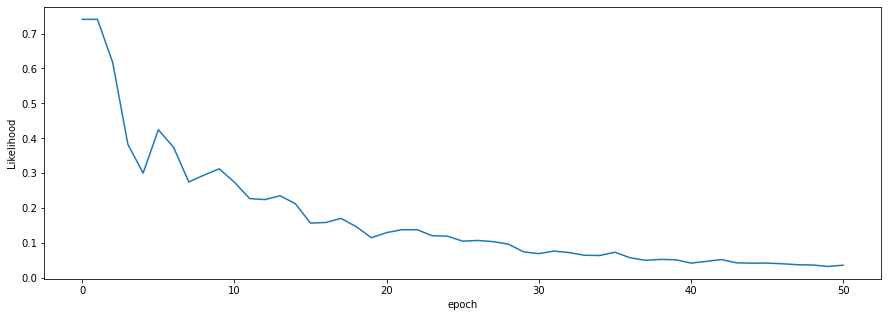

In [18]:
#Plot likelihood.
if haveData:
    plt.figure(figsize=(15, 5))
    plt.plot(nnet.get_error_trace())
    plt.xlabel('epoch')
    plt.ylabel('Likelihood')

### Plot a sample of the target and predicted classes
Since the dataset is large, only pull out a small random fraction of the results.  The sample selects the specified fraction of both targets.  

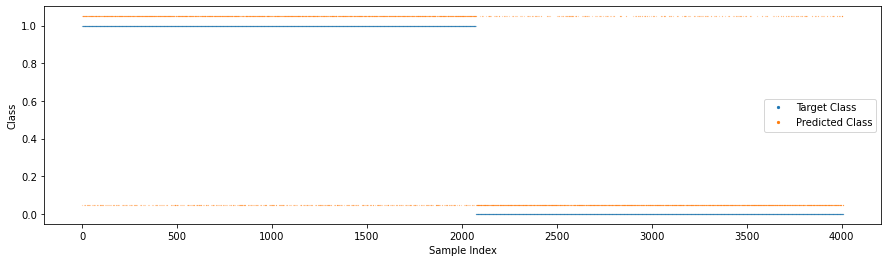

In [19]:
#Plot sample of target and predicted classes
if haveData:
    plotFraction = 0.002
    cloudyI, _ = np.where(TTest == 1)
    clearI,  _ = np.where(TTest == 0)
    nCloudy = round(plotFraction*len(cloudyI))
    nClear = round(plotFraction*len(clearI))
    rowsPlot = np.hstack((cloudyI[:nCloudy], clearI[:nClear]))
    TPlot = TTest[rowsPlot, :]
    YPlot = YTest[rowsPlot, :]

    plt.figure(figsize=(15,4))
    plt.plot(TPlot, 'o', markersize=.11)
    plt.plot(YPlot + 0.05, 'o', markersize=.11)
    plt.xlabel('Sample Index')
    plt.ylabel('Class')
    plt.legend(['Target Class', 'Predicted Class'], markerscale=20)


### Plot the hidden layers

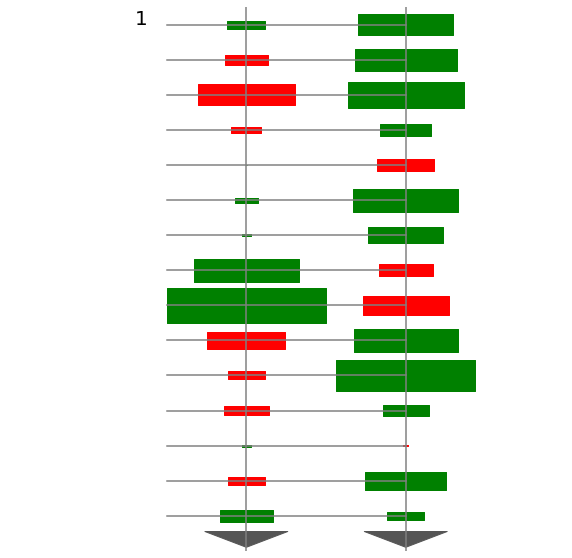

In [20]:
#Plot hidden layers
if haveData:
    plt.figure(figsize=(10,10))
    dnet.draw()

### Test different network setups

In [25]:
#Set the desired test information
testSetups = True
testIters = [10]  #[10, 100, 1000]
testMethods = ['scg', 'adam']  #['sgd','adam','scg']
testHiddens = [[],[10],[40],[10, 10],[10, 10, 10]]
testLR = [0.1]  #[0.1, 0.01]
testMR = [0.0] #[0.0, 0.01, 0.001]
testTorch = [False]
testGPU = False #only used when testTorch=True and remains this value (not looped)
printTests = False

In [26]:
#Run the tests
if haveData and testSetups:
    results = []
    for nIter in testIters:
        for mm in testMethods:
            for th in testHiddens:
                for tt in testTorch:
                    if ((mm == 'sgd') or (mm == 'adam')):
                        for tlr in testLR:
                            for tmr in testMR:
                                dnet = NeuralNetworkClassifier(X.shape[1], th, [0, 1], 
                                                           use_torch=tt, use_gpu=testGPU)
                                dnet.train(X, T, nIter, verbose=False, method=mm, 
                                       learning_rate=tlr, momentum_rate=tmr)
                                if printTests:
                                    print(dnet)
                                Yc,_ = dnet.use(X)
                                ncTrain = (Yc == T).sum()
                                traina = (ncTrain/T.shape[0]*100)
                                YTest,_ = dnet.use(XTest)
                                ncTest = (YTest == TTest).sum()
                                testa = (ncTest/TTest.shape[0]*100)
                                results.append([nIter, mm, th, tt, tlr, tmr, traina, testa, dnet.training_time])
                        
                    else:
                         dnet = NeuralNetworkClassifier(X.shape[1], th, [0, 1], 
                                                    use_torch=tt, use_gpu=testGPU)
                         dnet.train(X, T, nIter, verbose=False, method=mm)
                         if printTests:
                             print(dnet)
                         Yc,_ = dnet.use(X)
                         ncTrain = (Yc == T).sum()
                         traina = (ncTrain/T.shape[0]*100)
                         YTest,_ = dnet.use(XTest)
                         ncTest = (YTest == TTest).sum()
                         testa = (ncTest/TTest.shape[0]*100)
                         results.append([nIter, mm, th, tt, '', '', traina, testa, dnet.training_time])

    results = pandas.DataFrame(results, columns=('Iterations', 'Method', 'Hiddens', 'Torch', \
                                             'Learning Rate','Momentum','TrainA', 'TestA', 'Time'))

<ipython-input-7-c6fa41fac35a>:82: RuntimeWarning: overflow encountered in exp
  fs = self.exp(X @ w[1:,:] + w[0:1, :])
<ipython-input-7-c6fa41fac35a>:84: RuntimeWarning: invalid value encountered in true_divide
  return (fs/denom).to(self.mydest) if self.use_gpu else fs/denom
<ipython-input-7-c6fa41fac35a>:105: RuntimeWarning: divide by zero encountered in log
  M = self.mean(T * self.log(Y))
<ipython-input-7-c6fa41fac35a>:105: RuntimeWarning: invalid value encountered in multiply
  M = self.mean(T * self.log(Y))


In [27]:
#Show the results for the 10 highest test accuracies.
if haveData and testSetups:
    display((results.sort_values(by=['TestA'],ascending=False)).head(10))

Iterations Method       Hiddens  Torch Learning Rate Momentum     TrainA  \
7          10   adam          [40]  False           0.1        0  80.643887   
2          10    scg          [40]  False                         80.509203   
0          10    scg            []  False                         80.426597   
3          10    scg      [10, 10]  False                         80.408440   
8          10   adam      [10, 10]  False           0.1        0  80.408041   
4          10    scg  [10, 10, 10]  False                         80.357360   
5          10   adam            []  False           0.1        0  80.305482   
6          10   adam          [10]  False           0.1        0  80.009777   
9          10   adam  [10, 10, 10]  False           0.1        0  79.827805   
1          10    scg          [10]  False                         79.381853   

       TestA       Time  
7  80.682197  13.849961  
2  80.587869  25.487296  
0  80.486706   2.882735  
3  80.479174   9.181450  
8  80.447399   6.143359  
4  80.395920  12.471834  
5  80.342096   1.453303  
6  80.027485   3.533471  
9  79.850352   9.927634  
1  79.379259   2.474163

### Discussion

Based on the small tests above (using the inputs that are commented out, not the minimal set left in for faster running purposes with the basic notebook), the adam method performs the best, resulting in 83.96% accuracy with one hidden layer composed of 40 units, a learning rate of 0.1 and no momentum.  Interestingly, the top ten performers are all with the adam method and 100 iterations.  The only difference between the top three performers is the momentum, with decreasing accuracy with increasing momentum.  Following a single hidden layer, two hidden layers each of 10 units performs next best, followed by three hidden layers with 10 units.  The performance of the adam method was lowered with smaller learning rates of 0.1 and 0.01; however, in many setups these still outperformed both the SCG and SGD methods.   

Using SCG with the same setup as the top performing adam method results in a test accuracy of 81.55%, which is the second-best SCG performer.  The best SCG setup is with three hidden layers each of 10 units (and 100 iterations), which had a test accuracy of 81.73%.  

Using SGD did not perform well with these tests.  This is because it was not feasible to do all these combinations with more than 100 iterations; however, this SGD needed more iterations to compare more fairly on top performance regardless of the number of iterations required, because the likelihood was still changing relatively rapidly.  Because of the limited number of iterations, SGD was the lowest performer, and in a test case with 10 iterations, a learning rate of 0.01 and a momentum rate of 0.01, SGD had an accuracy of only 36%.

Analyses of likelihoods from the tests above suggest that the 100 iterations used were not sufficient to train the network.  I tested various setups outside this notebook, and so far the best performance I have obtained is 83.85% accuracy on the test dataset using the adam method with four hidden layers ([30, 20, 20, 20]).  The accuracy went down slightly when I added an additional layer ([20, 30, 20, 20, 20]) to 83.62%, indicating that the fifth layer was not able to add any information.  Using the scg method with five hidden layers yielded lower performance (83.02% accuracy).  I tried other setups using more units with less hidden layers (such as [40, 80], [80, 80], [80, 80, 80]), and the performance of these usually was ~82-83% with the test dataset.  These tests were all done with 1000 epochs, and their likelihood plots seems to indicate that the accuracy had stabilized after that many iterations.

It was also curious to me that the training and testing accuracies were similar.  To me this suggests that more data could be used in training and that might yield higher accucuracies.  I tested the dataset using the original partitions and obtained ~82% accuracy using 10 iterations with scg and a single hidden layer of 10 units.  The accuracy did improve using more data for training; however, the improvement came with longer required training time.  For this homework assignment, I did not pursue this further; however, future work investigating different partition fractions between training and testing data could yield improved performance.  

The accuracy obtained with neural networks is similar to or slightly better than that previously obtained using a random forest, indicating this approach has promise.  Future work could further investigate the optimal network setup as well as combinations of variables that may yield more information than each on their own.

# Notes

I developed a version of all appropriate code for a GPU, which can be used with a flag (use_gpu), tested this on Google Colab.  I found that this implementation is not optimized to use torch.  While the first several hundered iterations were indeed faster, beyond this using torch even on the GPU began to slow down to rates slower than using numpy.  

I spent time attempting to fix this implementation, but unfortunately I have not yet been successful.  To determine if any specific line was causing the slowdown, I put various timing statements in the scg routine, which you can active by swithcing a print flag at the top of that routine to True.  No specific routine appeared to be slow, there was just a general trend towards longer times between calls.  These results combine with information gleaned from testing and reading, I believe some torch tensors are being kept that are causing memory issues as the number of iterations increases.  Since we were recently shown python code designed to use torch methods, future work would be to switch to using their implementation or comparing this version to their code to see what is causing the slowing.